In [140]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [175]:
df['region'].value_counts()

region
FACE       362
CHEST      198
FOREARM    188
BACK       165
NOSE       141
ARM        111
HAND        73
NECK        73
EAR         58
THIGH       51
LIP         20
FOOT        15
ABDOMEN     14
SCALP        5
Name: count, dtype: int64

In [207]:
df = pd.read_csv(r"C:\Users\Mirka Gemelova\Downloads\df (1)")

# df.head()
# df.isnull().sum()
# df

y = df['diagnostic'].copy() #column with verdict: cancer or not cancer
#x = df.drop(col =['diagnostic', ], axis = 1)

best_features = ['elevation', 'bleed', 'smoke', 'grew', 'hurt', 'itch']
best_features = ['smoke','drink','pesticide','gender','skin_cancer_history','cancer_history','has_piped_water','has_sewage_system', 'itch','grew','hurt','changed','bleed','elevation','lesion_area']
best_features = ['elevation', 'bleed', 'lesion_area', 'grew', 'hurt']
#best_features = ['elevation', 'bleed', 'changed', 'smoke', 'grew', 'hurt', 'skin_cancer_history','cancer_history', 'itch', 'pest icide']  #we can add more
#best_features = ['elevation', 'bleed', 'changed', 'smoke', 'grew', 'hurt', 'skin_cancer_history','cancer_history', 'itch', 'age'] #maybe BINARISE the age!

x = df[best_features].copy()
#Best performing features: elevation, bleed, changed, smoke, grew, hurt, fitspat

#Deviding into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=101) #stratify = y makes sure that both training and test sets preserve the original class proportions.
#and then test to test and validation

x_train, x_validation,y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=101)

#This gives us:
#~64% training (x_train2)
#~16% validation (x_validation)
#~20% test (x_test)

In [208]:
x.head()

,elevation,bleed,lesion_area,grew,hurt
0,1,1,1.0,1,0
1,1,1,0.0,1,0
2,1,1,5.0,1,0
3,1,1,5.0,1,1
4,0,0,2.0,1,0


In [209]:
print(f'x_train : {x_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'x_validation : {x_validation.shape}')
print(f'y_validation : {y_validation.shape}')

x_train : (943, 5)
y_train : (943,)
x_validation : (236, 5)
y_validation : (236,)


In [210]:
#Building the model (not parameter tuned yet)
rf_model = RandomForestClassifier() #can change a LOT of parameters here n_
rf_model.fit(x_train, y_train)

RandomForestClassifier()

In [211]:
rf_model.score(x_validation, y_validation)

0.7796610169491526

In [212]:
#Building our predictions
y_pred = rf_model.predict(x_validation) #predict y (cancerous or not) based on the model

#checking accuracy on test
print("Accuracy:", accuracy_score(y_validation, y_pred))
print("Classification Report:\n", classification_report(y_validation, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_validation, y_pred))

Accuracy: 0.7796610169491526
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.44      0.51        62
           1       0.82      0.90      0.86       174

    accuracy                           0.78       236
   macro avg       0.72      0.67      0.68       236
weighted avg       0.76      0.78      0.77       236

Confusion Matrix:
 [[ 27  35]
 [ 17 157]]


In [213]:
#See what features were most important for this model
features = pd.DataFrame(rf_model.feature_importances_, index=x.columns )

features.head(10)

,0
elevation,0.253214
bleed,0.223246
lesion_area,0.376805
grew,0.085361
hurt,0.061374


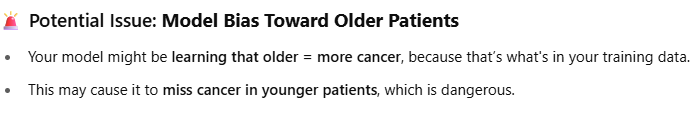

In [214]:
#RF with hyperparamaters
rf2 = RandomForestClassifier(n_estimators = 1000,
                             criterion = 'entropy',
                             min_samples_split = 10,
                             max_depth = 14,
                             random_state=101
)

In [215]:
rf2.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_split=10,
                       n_estimators=1000, random_state=101)

In [216]:
rf2.score(x_validation, y_validation)

0.7754237288135594

In [217]:
y_pred2 = rf2.predict(x_validation)

In [218]:
print(classification_report(y_validation, y_pred2))

              precision    recall  f1-score   support

           0       0.61      0.40      0.49        62
           1       0.81      0.91      0.86       174

    accuracy                           0.78       236
   macro avg       0.71      0.66      0.67       236
weighted avg       0.76      0.78      0.76       236



In [219]:
#Parameter tuning - Using Gridsearch and Random
param_grid = [{
    'n_estimators':[100,200,500], #More trees = better performance up to a point, then diminishing returns.
    'max_depth': [5, 10, 20, 30], #higher the values the more we risk overfitting
    'criterion': ['entropy', 'gini'], #can also comment this out
    'min_samples_split': [5,10,15], # minimum number of samples a node must have to be split into two child nodes in a decision tree. Default is 2 (canm overfit)
    'min_samples_leaf': [1, 2, 4]#,
    #'max_features': ['sqrt', 'log2', None]

}]

random_param_grid = [{
    'n_estimators':[100,200,500], #More trees = better performance up to a point, then diminishing returns.
    'max_depth': [5, 10, 20, 30], #higher the values the more we risk overfitting
    'criterion': ['entropy', 'gini'],
    'min_samples_split': [5,10,15], # minimum number of samples a node must have to be split into two child nodes in a decision tree. Default is 2 (canm overfit)
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]

}]

There are three main methods:

- Grid Search (try every combo — slow but thorough)
- Randomized Search (faster, tries a random sample of hyperparameters)
- Bayesian/Automated Search (advanced, e.g., Optuna, Hyperopt)

In [220]:
from sklearn.model_selection import GridSearchCV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
grid_search = GridSearchCV(rf_model,
                           param_grid,
                           cv=skf, #this splits testing data to test and validation based on cancer/non-cancer proportions (so they have same percentage of cancer)
                                    #if we use this, we dont have to split training data ourselves at the beginning
                           scoring = 'recall',
                           n_jobs=-1,                          
                           )

In [221]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [5, 10, 20, 30],
                          'min_samples_leaf': [1, 2, 4],
                          'min_samples_split': [5, 10, 15],
                          'n_estimators': [100, 200, 500]}],
             scoring='recall')

In [222]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.9354779033915724
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 200}


In [223]:
# from sklearn.model_selection import RandomizedSearchCV

# random_grid_search = RandomizedSearchCV(
#     estimator=rf_model,
#     param_distributions=random_param_grid,
#     n_iter=50,                 # n_iter is number of random combinations to try (instead of multiplying across)
#     cv=5,                      # 5-fold cross-validation
#     verbose=1,                 
#     n_jobs=-1,#
#     scoring='recall',        
#     random_state=101
# )

In [224]:
#random_grid_search.fit(x_train, y_train)

In [225]:
#print(random_grid_search.best_score_)
#print(random_grid_search.best_params_)

In [226]:
#Training the rf with what criteria recomended by grid search (= best parameters)
best_params = grid_search.best_params_

rf_final = RandomForestClassifier(**best_params, random_state=101) #if we want to increase recall for 0 (lower false positive), add here: class_weight='balanced'
rf_final.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=15,
                       n_estimators=200, random_state=101)

In [227]:
# Predicting probabilities on the validation set
probs_val = rf_final.predict_proba(x_validation)[:, 1]
threshold = 0.63  #by default rf have threshold 0.5, I tried to adjust this to increse recall for 0
y_pred_val_thresh = (probs_val >= threshold).astype(int)

print("Validation Report with adjusted threshold:")
print(classification_report(y_validation, y_pred_val_thresh))
print("Confusion Matrix:")
print(confusion_matrix(y_validation, y_pred_val_thresh))

Validation Report with adjusted threshold:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56        62
           1       0.84      0.84      0.84       174

    accuracy                           0.77       236
   macro avg       0.70      0.70      0.70       236
weighted avg       0.77      0.77      0.77       236

Confusion Matrix:
[[ 35  27]
 [ 27 147]]


In [228]:
import numpy as np
from sklearn.metrics import recall_score

probs_val = rf_final.predict_proba(x_validation)[:, 1]

thresholds = np.arange(0.3, 0.91, 0.05)

print("Threshold\tRecall_0\tRecall_1\tTotal_Accuracy")
print("-" * 50)

best_thresh = 0.5
best_recall_1 = 0
best_report = ""

for thresh in thresholds:
    preds = (probs_val >= thresh).astype(int)
    recall_0 = recall_score(y_validation, preds, pos_label=0)
    recall_1 = recall_score(y_validation, preds, pos_label=1)
    accuracy = (preds == y_validation).mean()
    
    print(f"{thresh:.2f}\t\t{recall_0:.2f}\t\t{recall_1:.2f}\t\t{accuracy:.2f}")

Threshold	Recall_0	Recall_1	Total_Accuracy
--------------------------------------------------
0.30		0.02		1.00		0.74
0.35		0.26		0.97		0.78
0.40		0.29		0.96		0.78
0.45		0.37		0.94		0.79
0.50		0.40		0.94		0.80
0.55		0.42		0.92		0.79
0.60		0.47		0.89		0.78
0.65		0.61		0.78		0.74
0.70		0.76		0.66		0.68
0.75		0.81		0.60		0.66
0.80		0.85		0.49		0.59
0.85		0.92		0.45		0.57
0.90		0.95		0.33		0.49


In [229]:
probs_test = rf_final.predict_proba(x_test)[:, 1]
y_pred_test_thresh = (probs_test >= threshold).astype(int)

print("Test Report with adjusted threshold:")
print(classification_report(y_test, y_pred_test_thresh))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_thresh))

Test Report with adjusted threshold:
              precision    recall  f1-score   support

           0       0.52      0.56      0.54        77
           1       0.84      0.82      0.83       218

    accuracy                           0.75       295
   macro avg       0.68      0.69      0.69       295
weighted avg       0.76      0.75      0.75       295

Confusion Matrix:
[[ 43  34]
 [ 39 179]]


In [230]:
#Evaluating on validation and test set
y_val_pred = rf_final.predict(x_validation)
print("Validation Report:")
print(classification_report(y_validation, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_validation, y_val_pred))

y_test_pred = rf_final.predict(x_test)
print("\nTest Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Validation Report:
              precision    recall  f1-score   support

           0       0.69      0.40      0.51        62
           1       0.81      0.94      0.87       174

    accuracy                           0.80       236
   macro avg       0.75      0.67      0.69       236
weighted avg       0.78      0.80      0.78       236

Confusion Matrix:
 [[ 25  37]
 [ 11 163]]

Test Report:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        77
           1       0.81      0.89      0.85       218

    accuracy                           0.77       295
   macro avg       0.69      0.65      0.66       295
weighted avg       0.75      0.77      0.75       295

Confusion Matrix:
 [[ 31  46]
 [ 23 195]]


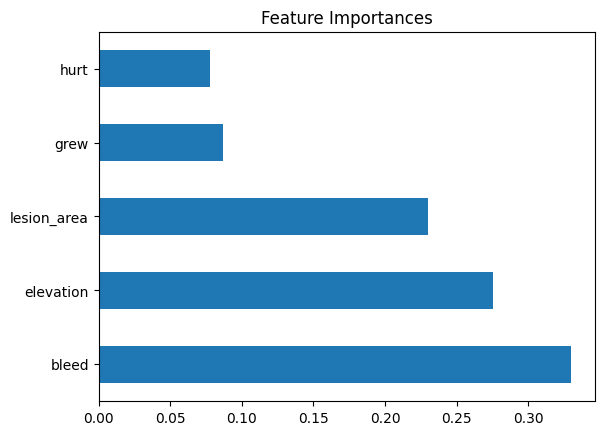

In [232]:
feat_importances = pd.Series(rf_final.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature Importances")
plt.show()

#elevation, bleed, lesion_area, grew, hurt

Notes:
We can argue for high recall on 1 (90% +) if we assume the model is used for SCREENING (so not for diagnosis)


smoke, elev, bleed, changed, grow, hurt, itch (changed, cancer histories)
- Anna
- all but bullshit